In [3]:
from ndlib.models.DiffusionModel import DiffusionModel
import ndlib.models.ModelConfig as mc
import numpy as np
from random import choice
import random
from random import seed, choice
import future.utils
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import time

In [62]:
class AlmondoModel(DiffusionModel):
    
    def __init__(self, graph, seed=None):
        super(self.__class__, self).__init__(graph, seed)

        self.discrete_state = False

        self.parameters = {
            "model": {
                "p_o": {
                    "descr": "Probability of event optimist model",
                    "range": [0, 1],
                    "optional": False
                },
                "p_p": {
                    "descr": "Probability of event pessimist model",
                    "range": [0, 1],
                    "optional": False
                },
                "l":{
                    "descr": "underreaction parameter",
                    "range": [0,1],
                    "optional": False
                }
            },
            "nodes": {},
            "edges": {}
        }

        self.name = "Almondo"
        self.n = self.graph.number_of_nodes()
        self.seed = seed
        self.status = None

    def set_initial_status(self, configuration=None, status=None):
        super(AlmondoModel, self).set_initial_status(configuration)        
        
        if status is None:
            self.status = np.random.rand(self.n)
        else:
            self.status = status        
            
            
    # updating rule, optimist model
    def optimist_update(self, w, s):
        p_o = self.params['model']['p_o']
        p_p = self.params['model']['p_p']
        l = self.params['model']['l']
        p = w * p_o + (1 - w) * p_p
        return l * w + (1 - l) * w * (s * (p_o / p) + (1 - s) * ((1 - p_o) / (1 - p)))

    def iteration(self, node_status=True):
        actual_status = self.status.copy()

        if self.actual_iteration == 0:
            self.actual_iteration += 1
            if node_status:
                return {"iteration": 0, "status": actual_status, "sender": None, "signal": None}
            else:
                return {"iteration": 0, "status": {}, "sender": None, "signal": None}
        
        #choose a sender at random
        sender = random.randint(0, self.n-1)
        
        # interact with peers
        p = actual_status[sender] * self.params['model']['p_o'] + (1- actual_status[sender]) * self.params['model']['p_p']
        signal = np.random.binomial(1, p)
        receivers = np.array(self.graph.neighbors(sender))
        
        #update rule
        actual_status[receivers] = self.optimist_update(actual_status[receivers], signal)  
        
        self.actual_iteration += 1   
        self.status = actual_status 
        
        if node_status:
            return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}
        else:
            return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}
        
    
    def iteration_bunch(self, T=100):
        random.seed(self.seed)
        system_status = []
        for it in tqdm(range(T)):
            its = self.iteration()
            system_status.append(its)       
        return system_status

    def steady_state(self, max_iterations=100000000, nsteady=1000, sensibility=0.00001, node_status=True, progress_bar=True, drop_evolution=True):             
        system_status = []
        steady_it = 0

        for it in tqdm(range(max_iterations)):

            its = self.iteration(node_status=True)
            
            if it > 0:
                old = system_status[-1]['status']
                actual = its['status']
                res = np.abs(old - actual)
                if np.all((res < sensibility)):
                    steady_it += 1
                else:
                    steady_it = 0
                    
            system_status.append(its)
            
            print(len(system_status))

            if steady_it == nsteady:
                print(f'Convergence reached after {it} iterations')
                return system_status
                    
        return system_status
    
    


In [5]:
#read inputs
# Read the edge list from CSV file
file_path = 'data/in/edge_list.csv'
df = pd.read_csv(file_path, header=None, names=['source', 'target'])
# Create a directed graph using networkx
G = nx.from_pandas_edgelist(df, source='source', target='target', create_using=nx.DiGraph())
G = nx.relabel_nodes(G, mapping={old: old-1 for old in list(G.nodes())})
print(G.number_of_nodes())
print(G.number_of_edges())
print(G.number_of_nodes()/G.number_of_edges())
# Read the CSV file into a DataFrame
file_path = 'data/in/weights_matrix.csv'
df = pd.read_csv(file_path, header=None)
# Extract the first column as a numpy array of floats
initial_status = df.iloc[:, 0].values.astype(float)
# Print the numpy array
initial_status = np.array(initial_status)
print(len(initial_status))
print(initial_status)

1000
500265
0.001998940561502404
1000
[5.73548496e-01 4.74623851e-02 3.71392071e-01 4.33609575e-01
 4.03384507e-01 5.92206240e-01 1.62714347e-01 3.62671882e-01
 4.50700343e-01 6.47293985e-01 5.19296110e-01 8.07919741e-01
 4.71872687e-01 7.37152934e-01 6.77654266e-01 8.37738156e-01
 7.75136530e-01 4.30871964e-01 8.92051578e-01 1.62640989e-01
 2.72712670e-03 6.54484689e-01 3.89510274e-01 6.31080121e-02
 8.54112744e-01 3.37660193e-01 5.67556739e-01 1.22783184e-01
 6.70370281e-01 3.25762004e-01 8.88086438e-01 9.67415750e-01
 8.49749029e-01 1.17679976e-01 7.74103105e-01 1.69653907e-01
 9.56089497e-01 5.37120223e-01 4.96006012e-02 1.22159354e-01
 7.82273710e-02 8.35439563e-01 7.74300814e-01 2.87056446e-01
 2.84544915e-01 7.62283325e-01 8.58836949e-01 1.25597298e-01
 5.75804412e-01 7.80850291e-01 5.37173897e-02 9.29993391e-01
 8.60321820e-01 9.88477528e-01 1.64782107e-01 9.60366488e-01
 2.80884594e-01 2.00289190e-01 5.34337386e-02 2.11170882e-01
 1.38225541e-01 9.65391695e-01 7.86964774e-01 2

In [6]:
import networkx as nx

p_o = 0.01
p_p = 0.99
l = 0.8
# n = 1000
# p_er = 0.01

# Network topology
g = G

# Model selection
model = AlmondoModel(graph=g, seed=4)

print(model)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("p_o", p_o)
config.add_model_parameter("p_p", p_p)
config.add_model_parameter("l", l)
model.set_initial_status(configuration=config, status=initial_status)



In [7]:
iterations = model.iteration_bunch(T=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

#### Initial distribution of weights on the optimist model

In [9]:
weights = iterations[0]['status']

(-0.05, 1.05)

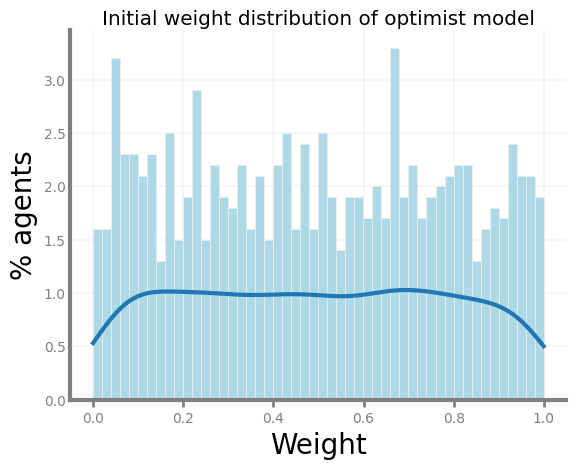

In [10]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(weights, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel('Weight')
ax.set_ylabel('% agents')
ax.set_title('Initial weight distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Initial probabilities distribution

In [11]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(-0.05, 1.05)

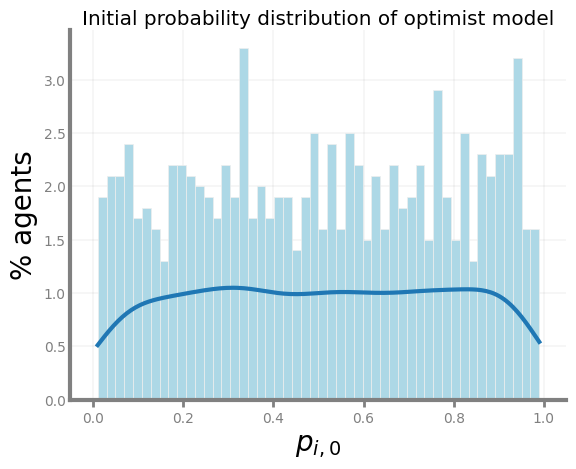

In [12]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,0}$')
ax.set_ylabel('% agents')
ax.set_title('Initial probability distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Final distributions

In [13]:
weights = iterations[-1]['status']

In [14]:
min(weights)

1.6109771510240484e-47

In [15]:
max(weights)

9.582548099540766e-32

Text(0.5, 1.0, 'Final weights distribution of optimist model')

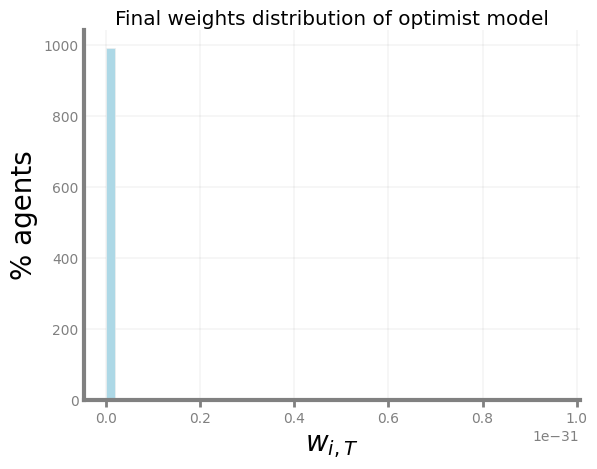

In [16]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0)
ax.set_xlabel(r'$w_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final weights distribution of optimist model')


In [17]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(0.0, 1.0)

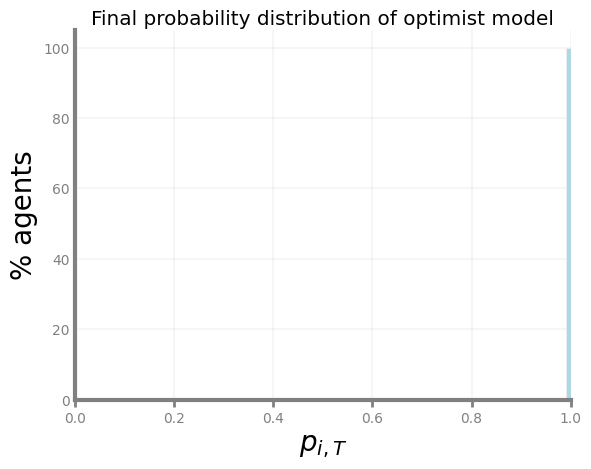

In [18]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
# sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of optimist model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

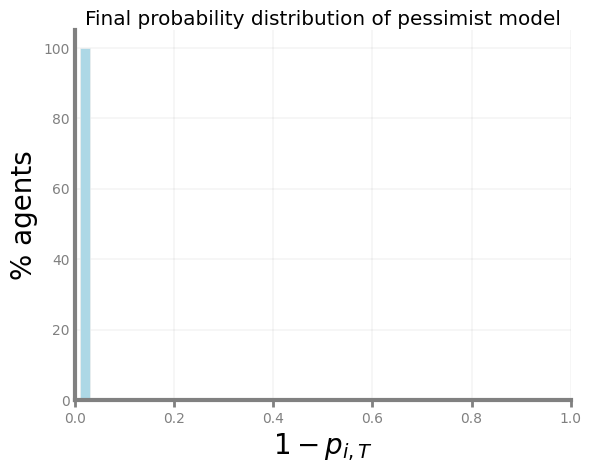

In [19]:
probabilities = 1-probabilities
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
ax.set_xlabel(r'$1 - p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of pessimist model')
ax.set_xlim(0.0, 1.0)

In [20]:
from matplotlib.colors import LinearSegmentedColormap

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']
spaghetti_cmap=get_continuous_cmap(spaghetti_hex_list)


def plotevolution(iterations, name=None, run=None, path='../plots/'):
    
    fig, ax = plt.subplots()

    spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']


    """
    Generates the plot

    :param filequintet: Output filequintet
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}
    
    p_o = 0.01
    p_p = 0.99

    for it in iterations:
        weights = it['status']
        sts = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur
        its = it['iteration']
        for n, v in enumerate(sts):
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = spaghetti_hex_list[0]
                elif 0.33 <= v <= 0.66:
                    node2col[n] = spaghetti_hex_list[1]
                else:
                    node2col[n] = spaghetti_hex_list[2]

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1.5, alpha=0.5, color=node2col[k])
    plt.xlabel('t')
    plt.ylabel(r'$p_{i,t}$')
    plt.title('Optimist model probability evolution')
    plt.tight_layout()
    
    if name:
        plt.savefig(f'{path}/opinion_evolution_{name}_run{run}.png', bbox_inches='tight', facecolor='white')
    else:
        plt.show()
    plt.close()

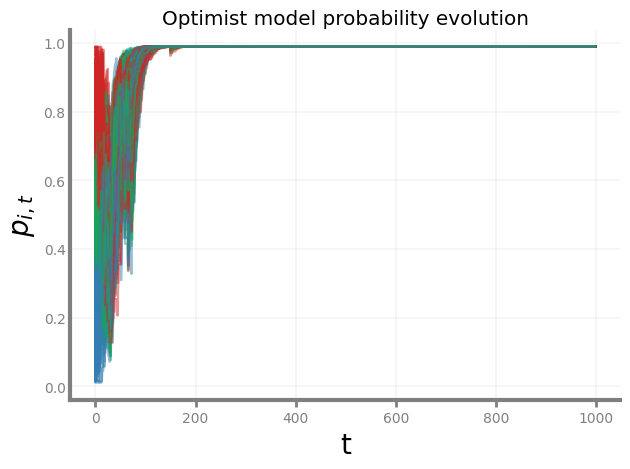

In [21]:
plotevolution(iterations)

# Il modello converge?

In [63]:
p_o = 0.01
p_p = 0.99
l = 0.8
# n = 1000
# p_er = 0.01

# Network topology
g = G

# Model selection
model = AlmondoModel(graph=g, seed=4)

print(model)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("p_o", p_o)
config.add_model_parameter("p_p", p_p)
config.add_model_parameter("l", l)
model.set_initial_status(configuration=config, status=initial_status)

In [64]:
iterations = model.steady_state(max_iterations=10000, nsteady=100, sensibility=0.001)

  0%|          | 0/10000 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
Convergence reached after 263 iterations


In [65]:
len(iterations)

264

#### Initial distribution of weights on the optimist model

In [68]:
weights = iterations[0]['status']

(-0.05, 1.05)

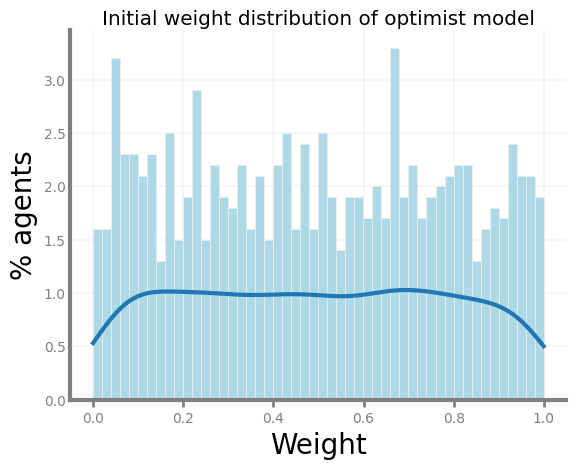

In [69]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(weights, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel('Weight')
ax.set_ylabel('% agents')
ax.set_title('Initial weight distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Initial probabilities distribution

In [70]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(-0.05, 1.05)

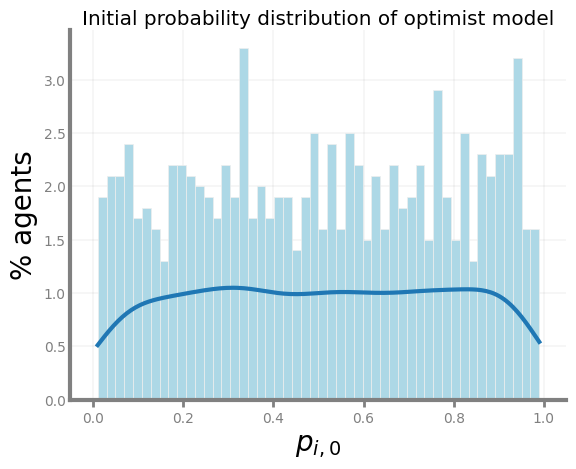

In [71]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,0}$')
ax.set_ylabel('% agents')
ax.set_title('Initial probability distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Final distributions

In [72]:
weights = iterations[-1]['status']

In [73]:
min(weights)

0.9999992792106343

In [74]:
max(weights)

0.9999999999995646

Text(0.5, 1.0, 'Final weights distribution of optimist model')

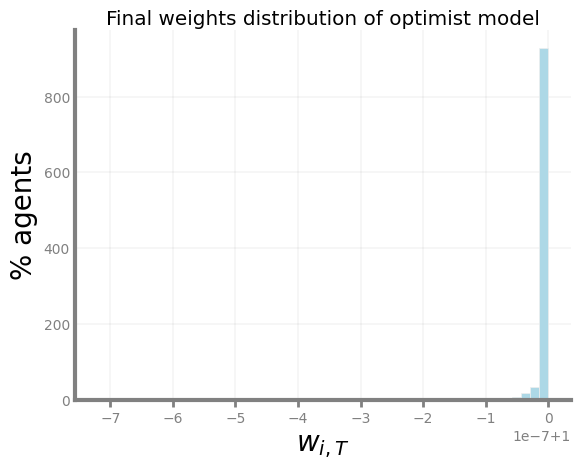

In [75]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0)
ax.set_xlabel(r'$w_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final weights distribution of optimist model')

In [77]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

In [80]:
probabilities

array([0.98999999, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.98999995, 0.99      , 0.98999999, 0.99      , 0.99      ,
       0.98999999, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.98999997, 0.98999999,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.98999999, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.98999999, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.98999999,
       0.99      , 0.99      , 0.98999999, 0.99      , 0.98999

(0.0, 1.0)

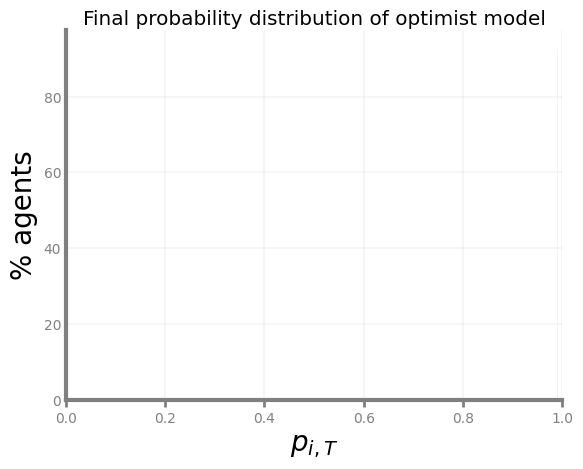

In [81]:
ax = sns.histplot(probabilities, bins = 50, color='lightblue', alpha=1.0, stat='percent')
# sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of optimist model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

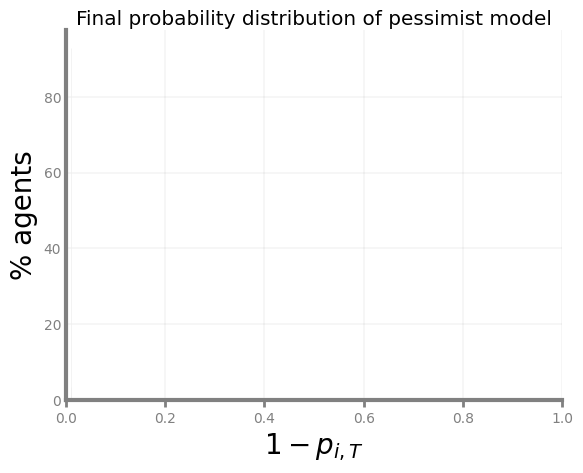

In [82]:
probabilities = 1-probabilities
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
ax.set_xlabel(r'$1 - p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of pessimist model')
ax.set_xlim(0.0, 1.0)

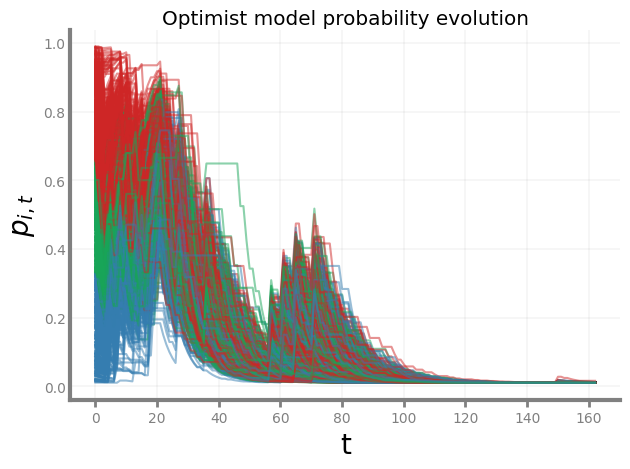

In [86]:
plotevolution(iterations[:len(iterations)-100])